*This document demonstrates how one can use python for analysis, and notebooks as environement for preliminary analysis*

# Importing libraries

(similar to `#include` in C++)


In [100]:
# First, import generic libraries for plot, ...

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [101]:
# then, import Histogram and TNTFile reader

from pytnt.TNTFileReader import TNTFileReader as tntreader
from pyHist.histogram import Histogram as hist

# Defining parameters for histograms

number of bins, limits, ....

In [102]:
tof_nbins = 3500
tof_min = 0.
tof_max = 7000.

egamma_nbins = 17500
egamma_min = -35000.
egamma_max = 35000.

# List of files to read

In [103]:
N_files = 4 # max = 35

input_files = ["/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_{0:04}.evt".format(i) 
               for i in range(1,N_files+1)]
               
print(input_files)


['/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0001.evt', '/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0002.evt', '/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0003.evt', '/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0004.evt']


# Define the histograms in lists

In [104]:
## Time histograms
tof_histograms = [
    hist(), # index 0: empty
    hist(tof_nbins, tof_min, tof_max),
    hist(tof_nbins, tof_min, tof_max),
    hist(tof_nbins, tof_min, tof_max),
    hist(tof_nbins, tof_min, tof_max),
]

## Energy histogram
energy_histograms = [
    hist(),
    hist(egamma_nbins, egamma_min, egamma_max),
    hist(egamma_nbins, egamma_min, egamma_max),
    hist(egamma_nbins, egamma_min, egamma_max),
    hist(egamma_nbins, egamma_min, egamma_max),
]

## Channels distribution
channels = hist(6, 0.5, 6.5)

# Now, the main reading loop: 

For each file, read all events in file, fill (the fast way) the corresponding histrogram

In [105]:
## Main Loop: reading the raw event file 
for inf in input_files:
    # Looping on event
    print('# Reading file "{0}" '.format(inf))
    for ev in tntreader(inf):
        if ev.channel==6:
            last_sync = ev.timestamp
            continue
        ev.tof=ev.timestamp-last_sync
        #
        channels.fast_fill(ev.channel)
        energy_histograms[ev.channel].fast_fill(ev.energy)
        tof_histograms[ev.channel].fast_fill(ev.tof)
        pass
    #end for event (in file)
    pass
#end for input_file

print("... Done")

# Reading file "/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0001.evt" 
# Reading file "/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0002.evt" 
# Reading file "/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0003.evt" 
# Reading file "/work/ghenning/W_analysis/data/efficacite-we-18-19/Card0105_0004.evt" 
... Done


# Checking...

`channel` histogram contains the number of counts per histogram:

In [106]:
print(channels)

# nbins = 6
# xmin = 0.5
# xmax = 6.5
0.5 1.0 11205770  
1.5 1.0 5470014  
2.5 1.0 7327212  
3.5 1.0 5957196  
4.5 1.0 0  
5.5 1.0 0  
# out of range = 0



In [107]:
# checking consitency (for exmaple channel 1)
print(sum(energy_histograms[1]), energy_histograms[1].outofrange)

(11205770.0, 0)


# Saving histogram to files

In [108]:
# Just `dumping` histogram to a file.

for i in (1,2,3,4):
    open("tof_chan{0}.hist.txt".format(i), 'w').write(str(tof_histograms[i]))
    open("energy_chan{0}.hist.txt".format(i), 'w').write(str(energy_histograms[i]))

In [109]:
# Checking the file content:

print(open("energy_chan1.hist.txt").read()[:400])

# nbins = 17500
# xmin = -35000.0
# xmax = 35000.0
-35000.0 4.0 0  
-34996.0 4.0 0  
-34992.0 4.0 0  
-34988.0 4.0 0  
-34984.0 4.0 0  
-34980.0 4.0 0  
-34976.0 4.0 0  
-34972.0 4.0 0  
-34968.0 4.0 0  
-34964.0 4.0 0  
-34960.0 4.0 0  
-34956.0 4.0 0  
-34952.0 4.0 0  
-34948.0 4.0 0  
-34944.0 4.0 0  
-34940.0 4.0 0  
-34936.0 4.0 0  
-34932.0 4.0 0  
-34928.0 4.0 0  
-34924.0 4.0 0  
-34920.0 


# Now, looking at a specific histogram

We'll try to get the peak width at 122 keV

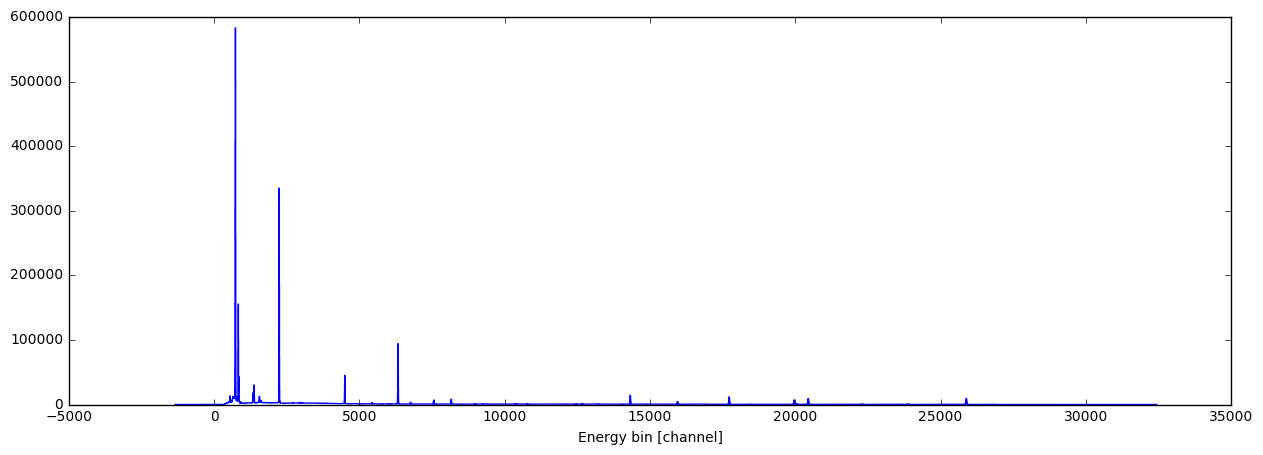

In [110]:
# Selecting channel 1
h = energy_histograms[1]

# Cleaning empty bins:
h.autocrop()

# plotting
plt.figure(figsize=(15,5))
plt.step(*h.xy(), where='post')
plt.xlabel("Energy bin [channel]")
plt.show()

The 122 keV pic is located around 2000 channel... Zooming in with `slice`

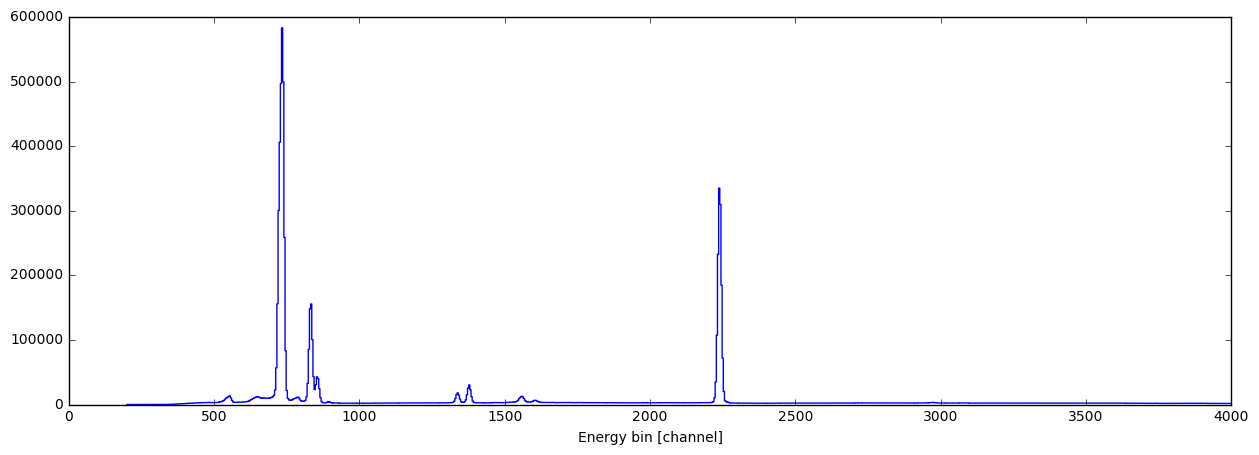

In [111]:
h_zoom1 = h.slice(200, 4000.)

plt.figure(figsize=(15,5))
plt.step(*h_zoom1.xy(), where='post')
plt.xlabel("Energy bin [channel]")
plt.show()

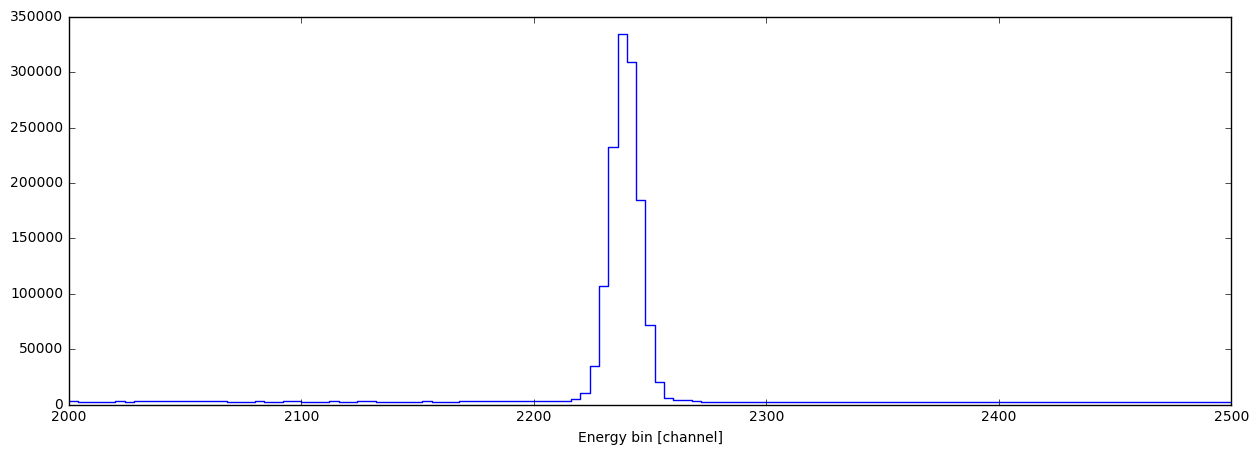

In [112]:
# zooming even more:

h_zoom2 = h.slice(2000., 2500.)

plt.figure(figsize=(15,5))
plt.step(*h_zoom2.xy(), where='post')
plt.xlabel("Energy bin [channel]")
plt.show()

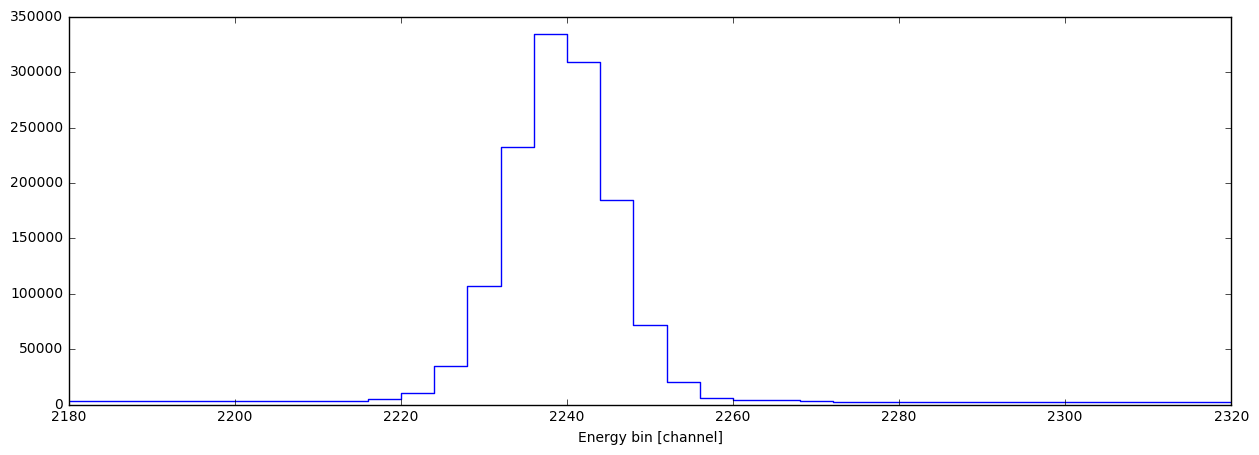

In [113]:
# just the peak:

h_122 = h.slice(2180., 2320.)

plt.figure(figsize=(15,5))
plt.step(*h_122.xy(), where='post')
plt.xlabel("Energy bin [channel]")
plt.show()

In [114]:
# I don't want to modify the original histogram, so I make a copy:

h_122 = h_122.copy()


Removing constant background component:

In [115]:
bg_level = min(h_122)
print(bg_level)

2320.0 4.0 2103.0 


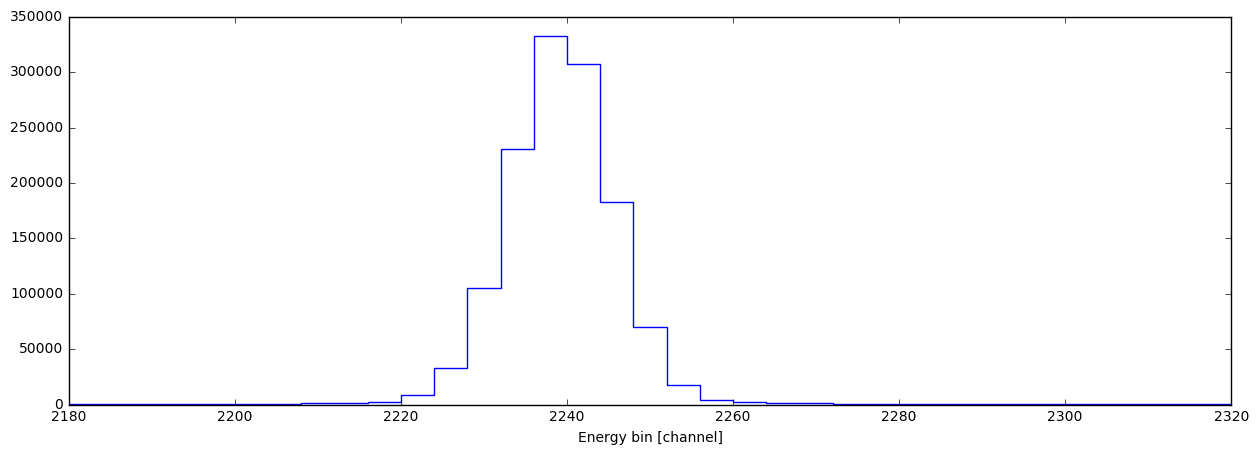

In [116]:
h_122_bgrm = h_122 - float(bg_level)

plt.figure(figsize=(15,5))
plt.step(*h_122_bgrm.xy(), where='post')
plt.xlabel("Energy bin [channel]")
plt.show()

In [117]:
print(h_122_bgrm)

# nbins = 36
# xmin = 2180.0
# xmax = 2324.0
2180.0 4.0 719.0  
2184.0 4.0 683.0  
2188.0 4.0 751.0  
2192.0 4.0 818.0  
2196.0 4.0 655.0  
2200.0 4.0 739.0  
2204.0 4.0 781.0  
2208.0 4.0 918.0  
2212.0 4.0 1316.0  
2216.0 4.0 2419.0  
2220.0 4.0 8290.0  
2224.0 4.0 32854.0  
2228.0 4.0 105143.0  
2232.0 4.0 230573.0  
2236.0 4.0 332871.0  
2240.0 4.0 307608.0  
2244.0 4.0 182713.0  
2248.0 4.0 69660.0  
2252.0 4.0 18055.0  
2256.0 4.0 4044.0  
2260.0 4.0 2194.0  
2264.0 4.0 1715.0  
2268.0 4.0 1161.0  
2272.0 4.0 454.0  
2276.0 4.0 246.0  
2280.0 4.0 209.0  
2284.0 4.0 104.0  
2288.0 4.0 96.0  
2292.0 4.0 96.0  
2296.0 4.0 115.0  
2300.0 4.0 80.0  
2304.0 4.0 38.0  
2308.0 4.0 119.0  
2312.0 4.0 118.0  
2316.0 4.0 93.0  
2320.0 4.0 0.0  
# out of range = 0



In [118]:
# Evaluating the position of the peak:

pos_max = max(h_122_bgrm).center()
print("Center of the maximum bin: "+str(pos_max))

pos_mean = sum([b.center()*b.count for b in h_122_bgrm])/sum(h_122_bgrm)
print("Mean bin center: "+str(pos_mean))

Center of the maximum bin: 2238.0
Mean bin center: 2239.14972548


In [119]:
# Evaluating the width of the peak: 
# (using sigma^2 = <x^2> - <x>^2)

stddev_sq = sum([b.center()**2.*b.count for b in h_122_bgrm])/sum(h_122_bgrm)-pos_mean**2.
stddev = stddev_sq**0.5

print("Peak width (std dev): "+str(stddev))

fwhm = stddev*2.35482
print("  -> FWHM: "+str(fwhm))


Peak width (std dev): 7.30849083579
  -> FWHM: 17.2101803899


In [120]:
# Now putting things in relative:

print("Relative FWHM: "+str(fwhm/pos_mean*100.)+" %")

Relative FWHM: 0.768603376278 %


The obtained value is close to the one we can guess from visual estimation: good

In [121]:
print("Actual FWHM: "+str(122.*fwhm/pos_mean)+ " keV")

Actual FWHM: 0.937696119059 keV
